In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras import models
from keras import layers
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import os, shutil
from tensorflow.python.client import device_lib 
%matplotlib inline

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13362043553123979758
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3131414939
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15111691832838128643
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [4]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
tf.debugging.set_log_device_placement(True)

In [7]:
df_meta = pd.read_csv('Chest_xray_Corona_Metadata.csv' , index_col=0)
df_meta

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...
5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


# Data Proprocessing

In [8]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5910 entries, 0 to 5932
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   X_ray_image_name        5910 non-null   object
 1   Label                   5910 non-null   object
 2   Dataset_type            5910 non-null   object
 3   Label_2_Virus_category  69 non-null     object
 4   Label_1_Virus_category  4334 non-null   object
dtypes: object(5)
memory usage: 277.0+ KB


<AxesSubplot:>

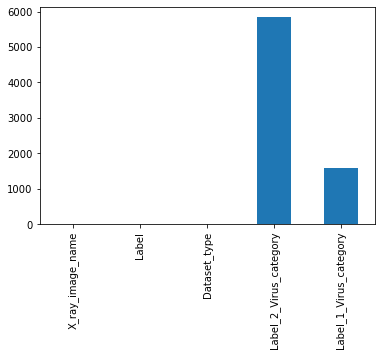

In [9]:
df_meta.isnull().sum().plot.bar()

<AxesSubplot:xlabel='Label_1_Virus_category'>

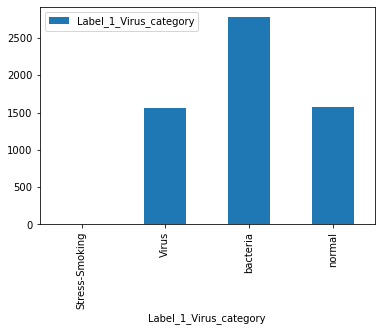

In [10]:
df_meta['Label_1_Virus_category'].fillna('normal' , inplace=True)
df_meta.pivot_table(index = 'Label_1_Virus_category' , aggfunc={'Label_1_Virus_category':'count'}).plot.bar()

<AxesSubplot:xlabel='Label_2_Virus_category'>

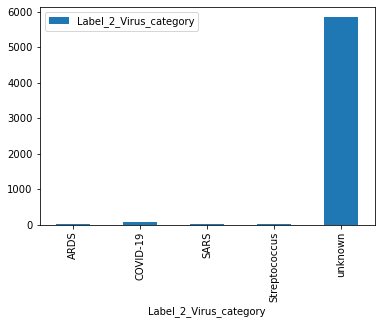

In [11]:
df_meta['Label_2_Virus_category'].fillna('unknown' , inplace=True)
df_meta.pivot_table(index = 'Label_2_Virus_category', aggfunc={'Label_2_Virus_category' : 'count'}).plot.bar()

In [12]:
df_train = df_meta[df_meta['Dataset_type'] == 'TRAIN']
df_test = df_meta[df_meta['Dataset_type'] == 'TEST']

print('shape Train Data :',df_train.shape)
print('shape Test Data :',df_test.shape)

shape Train Data : (5286, 5)
shape Test Data : (624, 5)


In [13]:
df_meta.columns

Index(['X_ray_image_name', 'Label', 'Dataset_type', 'Label_2_Virus_category',
       'Label_1_Virus_category'],
      dtype='object')

<AxesSubplot:xlabel='Label_1_Virus_category'>

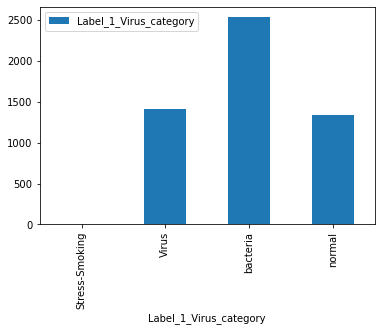

In [14]:
df_train.pivot_table(index = 'Label_1_Virus_category' , aggfunc= {'Label_1_Virus_category' : 'count'}).plot.bar()

<AxesSubplot:xlabel='Label_2_Virus_category'>

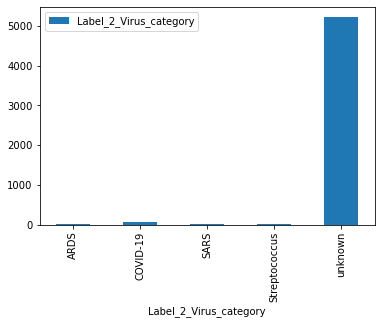

In [15]:
df_train.pivot_table(index = 'Label_2_Virus_category' , aggfunc= {'Label_2_Virus_category' : 'count'}).plot.bar()

<AxesSubplot:xlabel='Label_1_Virus_category'>

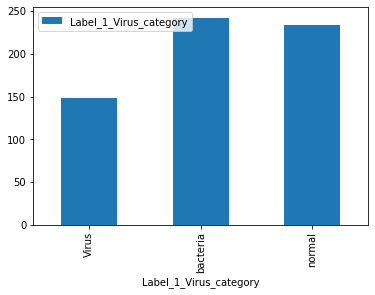

In [16]:
df_test.pivot_table(index = 'Label_1_Virus_category' , aggfunc= {'Label_1_Virus_category' : 'count'}).plot.bar()

<AxesSubplot:xlabel='Label_2_Virus_category'>

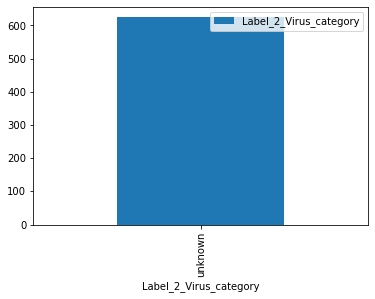

In [17]:
df_test.pivot_table(index = 'Label_2_Virus_category' , aggfunc= {'Label_2_Virus_category' : 'count'}).plot.bar()

## Split Train & Test 

In [18]:
train_dir = 'G:\Chest_xray_Corona_Metadata_1\Coronahack-Chest-XRay-Dataset\Coronahack-Chest-XRay-Dataset\\train\\'
test_dir = 'G:\Chest_xray_Corona_Metadata_1\\newdataset\\0\\'

name_list_train = list(df_train['X_ray_image_name'])
name_list_test = list(df_test['X_ray_image_name'])

In [19]:
df_train_f = df_train[(df_train['Label'] == 'Normal')|((df_train['Label'] == 'Pnemonia')&(df_train['Label_1_Virus_category'] == 'Virus')&(df_train['Label_2_Virus_category'] == 'COVID-19')|(df_train['Label_1_Virus_category'] == 'Virus'))]

df_train_f['class'] = df_train_f['Label']+'/'+df_train['Label_1_Virus_category']+'/'+df_train['Label_2_Virus_category']

def convert(x):
    if x == 'Normal/normal/unknown' :
        return '0'
    elif x == 'Pnemonia/Virus/COVID-19' :
        return '2'        
    else :
        return '1'

df_train_f['label'] = df_train_f['class'].apply(convert)
df_train_f.sample(3)

<ipython-input-19-8939c91b648f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_f['class'] = df_train_f['Label']+'/'+df_train['Label_1_Virus_category']+'/'+df_train['Label_2_Virus_category']
<ipython-input-19-8939c91b648f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_f['label'] = df_train_f['class'].apply(convert)


,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,class,label
1566,person105_virus_193.jpeg,Pnemonia,TRAIN,unknown,Virus,Pnemonia/Virus/unknown,1
1299,NORMAL2-IM-1294-0001.jpeg,Normal,TRAIN,unknown,normal,Normal/normal/unknown,0
357,IM-0544-0001.jpeg,Normal,TRAIN,unknown,normal,Normal/normal/unknown,0


In [20]:
df_train_f.groupby('label').count()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,class
label,,,,,,
0,1342,1342,1342,1342,1342,1342
1,1349,1349,1349,1349,1349,1349
2,58,58,58,58,58,58


In [21]:
df_train_f.shape

(2749, 7)

Label Image : 0


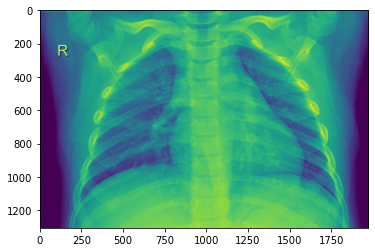

In [22]:
index = 1
img = plt.imread(train_dir + df_train_f['X_ray_image_name'][index])
plt.imshow(img)
print('Label Image :',df_train_f['label'][index])

## Split Data Covid-19

In [23]:
df_val_covid = df_train_f[df_train_f['label'] == '2']
df_val_covid.reset_index(inplace = True)
df_val_covid.shape

(58, 8)

kjr-21-e24-g001-l-a.jpg


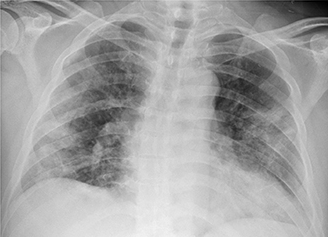

In [24]:
i = 3
print(df_val_covid['X_ray_image_name'][i])
load_img(train_dir+df_val_covid['X_ray_image_name'][i])

# Split Data Virus

In [25]:
df_virus = df_train_f[df_train_f['label'] == '1']
df_virus_valid = df_virus[:60]
df_virus = df_virus[60:]
df_virus = df_virus[['X_ray_image_name','label']]
df_val_virus = df_virus_valid[['X_ray_image_name','label']]
df_val_virus.head()

,X_ray_image_name,label
1341,person101_virus_188.jpeg,1
1342,person101_virus_187.jpeg,1
1343,person1019_virus_1708.jpeg,1
1344,person1019_virus_1707.jpeg,1
1346,person1018_virus_1706.jpeg,1


person1094_virus_1814.jpeg


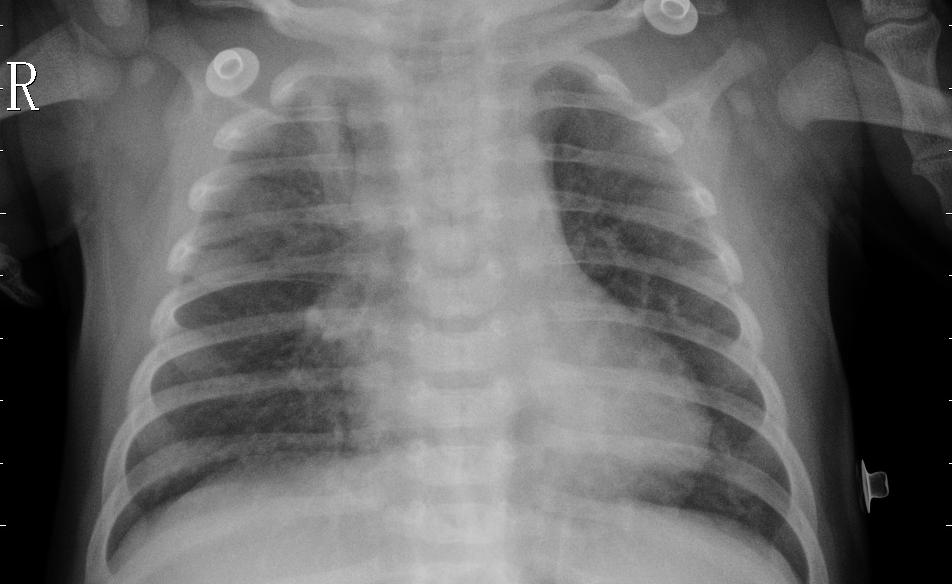

In [26]:
i = 1500
print(df_virus['X_ray_image_name'][i])
load_img(train_dir+df_virus['X_ray_image_name'][i])

## Data Augmentation

In [2]:
image_size = (64,64)
batch_size = 32

img_gen1 = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=[0.7,1.0],
    rotation_range= 60,
    rescale=1./255,
    brightness_range=[0.3,1.0],
    fill_mode = 'nearest'
)

img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [28]:
import errno, os, stat, shutil

def handleRemoveReadonly(func, path, exc):
  excvalue = exc[1]
  if func in (os.rmdir, os.remove) and excvalue.errno == errno.EACCES:
      os.chmod(path, stat.S_IRWXU| stat.S_IRWXG| stat.S_IRWXO) # 0777
      func(path)
  else:
      raise

shutil.rmtree('Chest_xray_Corona_Metadata', ignore_errors=False, onerror=handleRemoveReadonly)

In [29]:
# shutil.rmtree('img', ignore_errors=False, onerror=handleRemoveReadonly)
# aug_dir = os.path.join('G:\Chest_xray_Corona_Metadata', 'img')
# os.mkdir(aug_dir)

# list_cov = list()
# for i in range(df_val_covid.shape[0]):
#      img = load_img(train_dir+df_val_covid['X_ray_image_name'][i])
#      image = img_to_array(img)
#      x = image.reshape((1, ) + image.shape)

#      j = 0
#      for batch in img_gen1.flow(x, save_to_dir='img', save_prefix='aug-image-', save_format='jpeg') :
#          j += 1
#          if j > 20 :
#             break

In [30]:
random.seed(3)
df_train_f = shuffle(df_train_f , random_state = 1)

df_train_f = df_train_f[df_train_f['label'] == '0']

df_val_normal = df_train_f[:60]
#df_test_notcovid = df_train_f[60:90]
df_train_f = df_train_f[60:]

## Creat Filename Augmentation Dataframe

In [31]:
original = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
path_aug = 'img'
files = os.listdir(path_aug)
name = list()
for file in files :
    name.append(file)

df_aug = pd.DataFrame(name , columns = ['X_ray_image_name'])
df_aug['label'] = '2'
df_aug

,X_ray_image_name,label
0,aug-image-_0_1002.jpeg,2
1,aug-image-_0_1023.jpeg,2
2,aug-image-_0_1024.jpeg,2
3,aug-image-_0_1038.jpeg,2
4,aug-image-_0_1043.jpeg,2
...,...,...
1147,aug-image-_0_9975.jpeg,2
1148,aug-image-_0_9977.jpeg,2
1149,aug-image-_0_9978.jpeg,2
1150,aug-image-_0_998.jpeg,2


## Copy Augmentation IMG to Train Folder

In [32]:
img_dir = 'img'

fname_aug= df_aug['X_ray_image_name'].to_list()

for fname in fname_aug:
    src = os.path.join(img_dir, fname) 
    dst = os.path.join(train_dir, fname) 
    shutil.copyfile(src, dst)

## Create Dataframe Trainset Augment+Original 

In [33]:
df_train_f1 = pd.concat([df_train_f,df_virus,df_aug]).reset_index()
df_train_f1.drop(columns='index' , inplace = True)
df_train_f1 = df_train_f1[['X_ray_image_name' , 'label']]

In [34]:
df_train_f1.label.value_counts()

1    1289
0    1282
2    1152
Name: label, dtype: int64

## Create Dataframe Testset Covid Original + Normal Original 

In [35]:
df_train_normal = df_train_f1[df_train_f1['label'] == '0']
df_train_virus = df_train_f1[df_train_f1['label'] == '1']
df_train_covid= df_train_f1[df_train_f1['label'] == '2']

In [36]:
print(df_train_normal.shape)
print(df_train_virus.shape)
print(df_train_covid.shape)

print(df_val_normal.shape)
print(df_val_virus.shape)
print(df_val_covid.shape)

(1282, 2)
(1289, 2)
(1152, 2)
(60, 7)
(60, 2)
(58, 8)


## Create Directory train & Validation & Test

In [37]:
# Clear Test Img from Folder newdata/0
files = os.listdir(test_dir)
names = list()
for file in files :
    names.append(file)
df_del = pd.DataFrame(names , columns= ['X_ray_image_name'])
f_name_test = df_del['X_ray_image_name'].to_list()

for f_name in f_name_test :
    path = 'newdataset\\0'+'\\'+f_name
    print(path)
    os.remove(path)

## Create Folde Train Validation Test

In [38]:
base_dir = 'Chest_xray_Corona_Metadata' 
base_dir1 = 'newdataset'
os.mkdir(base_dir)

#Directory for the training set
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

#Directory for the validation set
validation_dir = os.path.join(base_dir, 'validation') 
os.mkdir(validation_dir)

#Directory for the test set
#test_dir = os.path.join(base_dir1, '0') 
#os.mkdir(test_dir)

#Directory with training nnormal pictures
train_normal_dir = os.path.join(train_dir, '0') 
os.mkdir(train_normal_dir)

#Directory with training virus pictures
train_virus_dir = os.path.join(train_dir, '1') 
os.mkdir(train_virus_dir)

#Directory with training covid pictures
train_covid_dir = os.path.join(train_dir, '2') 
os.mkdir(train_covid_dir)

#Directory with val normal pictures
val_normal_dir = os.path.join(validation_dir, '0') 
os.mkdir(val_normal_dir)

#Directory with val virus pictures
val_virus_dir = os.path.join(validation_dir, '1') 
os.mkdir(val_virus_dir)

#Directory with val covid pictures
val_covid_dir = os.path.join(validation_dir, '2') 
os.mkdir(val_covid_dir)

## Copy Image To folder

In [39]:
fname_train_normal = df_train_normal['X_ray_image_name'].to_list()
fname_train_virus = df_train_virus['X_ray_image_name'].to_list()
fname_train_covid = df_train_covid['X_ray_image_name'].to_list()

fname_val_normal = df_val_normal['X_ray_image_name'].to_list()
fname_val_virus = df_val_virus['X_ray_image_name'].to_list()
fname_val_covid = df_val_covid['X_ray_image_name'].to_list()

#fname_test_notcovid = df_test_notcovid['X_ray_image_name'].to_list()

In [40]:
for fname in fname_train_normal:
    src = os.path.join(original, fname) 
    dst = os.path.join(train_normal_dir, fname) 
    shutil.copyfile(src, dst)

for fname in fname_train_covid:
    src = os.path.join(original, fname) 
    dst = os.path.join(train_covid_dir, fname) 
    shutil.copyfile(src, dst)

for fname in fname_train_virus:
    src = os.path.join(original, fname) 
    dst = os.path.join(train_virus_dir, fname) 
    shutil.copyfile(src, dst)

for fname in fname_val_normal:
    src = os.path.join(original, fname) 
    dst = os.path.join(val_normal_dir, fname) 
    shutil.copyfile(src, dst)

for fname in fname_val_covid:
    src = os.path.join(original, fname) 
    dst = os.path.join(val_covid_dir, fname) 
    shutil.copyfile(src, dst)

for fname in fname_val_virus:
    src = os.path.join(original, fname) 
    dst = os.path.join(val_virus_dir, fname) 
    shutil.copyfile(src, dst)

#for fname in fname_test_notcovid:
#    src = os.path.join(original, fname) 
#    dst = os.path.join(test_dir, fname) 
#    shutil.copyfile(src, dst)

## Create Frow Image

In [41]:
train_img = img_gen.flow_from_directory(
    train_dir ,
    target_size = image_size ,
    batch_size = batch_size ,
    class_mode = 'categorical',
    classes = ['0','1','2'],
    seed = 25 ,
    shuffle = True  
)

valid_img = img_gen.flow_from_directory(
    validation_dir ,
    target_size = image_size ,
    batch_size = batch_size ,
    class_mode = 'categorical',
    classes = ['0','1','2'],
    seed = 25 ,
    shuffle = False  
)

Found 3723 images belonging to 3 classes.
Found 178 images belonging to 3 classes.


# Model Build : CNN Deep Learning

In [42]:
with tf.device('/gpu:0'):
    model = models.Sequential()

    model.add(Conv2D(32, (3,3), padding='same',input_shape=[64,64,3]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(400, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(512, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(3000, activation='relu' ,kernel_initializer = 'he_uniform'))
    model.add(Dropout(0.2))

    model.add(Dense(3, activation='softmax'))

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

In [44]:
opt = keras.optimizers.Adam(lr=0.00003,beta_1=0.9 , beta_2=0.999)
model.compile(optimizer= opt , loss= 'categorical_crossentropy',metrics=['categorical_accuracy'])
earlystopping = EarlyStopping(monitor='val_loss',
                            min_delta=0.0,
                            patience=10,
                            mode = 'min',
                            verbose=1) 


Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [45]:
epoch = 50
step_train = train_img.samples/batch_size
step_val = valid_img.samples/batch_size

In [46]:
history = model.fit(train_img,
                    steps_per_epoch = step_train ,
                    epochs=epoch ,
                    validation_data=(valid_img),
                    validation_steps = step_val,
                    callbacks = [earlystopping])

.0080 - categorical_accuracy: 0.9948Executing op __inference_train_function_1876 in device /job:localhost/replica:0/task:0/device:GPU:0
117/116 [==============================] - ETA: 0s - loss: 0.0041 - categorical_accuracy: 0.9980Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


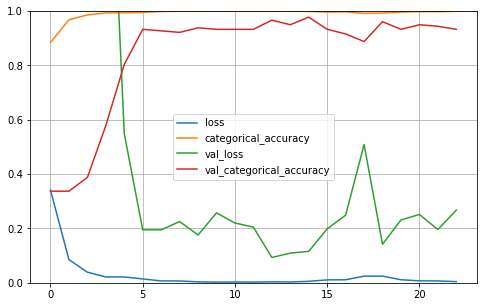

In [47]:
pd.DataFrame(history.history).plot(figsize=(8,5)) 
plt.grid(True)
plt.ylim(0,1)
plt.show()

In [48]:
pred = model.predict(valid_img)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

In [49]:
print('Confusion Matrix')
print(confusion_matrix(valid_img.classes, pred.argmax(axis=1)))
print('Classification Report')
print(classification_report(valid_img.classes, pred.argmax(axis=1)))

Confusion Matrix
[[58  2  0]
 [ 7 53  0]
 [ 1  2 55]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        60
           1       0.93      0.88      0.91        60
           2       1.00      0.95      0.97        58

    accuracy                           0.93       178
   macro avg       0.94      0.93      0.93       178
weighted avg       0.94      0.93      0.93       178



In [55]:
model.save('Model_Save')

:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/

# Test Data

In [3]:
model_h = keras.models.load_model('Model_Save')

In [6]:
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_covid_img = test_gen.flow_from_directory(
    'newdataset' ,
    target_size = image_size ,
    batch_size = batch_size ,
    class_mode = 'categorical',
    shuffle= False
)
step_test = test_covid_img.samples/batch_size

Found 1 images belonging to 3 classes.


In [ ]:
test_pred = model_h.predict(test_covid_img)

In [ ]:
test_pred.argmax(axis=1)

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(test_covid_img.classes, test_pred.argmax(axis=1)))
print('Classification Report')
print(classification_report(test_covid_img.classes, test_pred.argmax(axis=1)))